# Make tables: calculate p-values and differential expressions for each cancer 

Create a dataframe with p-value results from t-tests for all proteins (trans proteomics when KRAS has missense mutations compared to KRAS wildtype). The dataframe also includes the change in medians between deletions and wildtype. Prepare these tables for further analysis by creating csv files.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import gseapy as gp
import re
import sys 

import cptac
import cptac.utils as u
import plot_utils as p

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def get_all_interacting_proteins(gene, num_results_in = 25):
    bioplex_list = list(u.get_interacting_proteins_bioplex(gene))
    wiki_list = list(u.get_interacting_proteins_wikipathways(gene))

    biogrid_list = list(u.get_interacting_proteins_biogrid(gene, num_results=num_results_in))
    string_list = list(u.get_interacting_proteins_string(gene, num_results=num_results_in))

    all_int = bioplex_list + wiki_list + biogrid_list + string_list
    interacting_list = list(set(all_int))
    interacting_list.remove(gene) # remove cis
    
    return interacting_list

In [4]:
# Returns a dataframe with proteomics and mutation type

# all_prot: list of trans genes

def all_prot_format_df(cancer_object, all_prot, gene_in = 'KRAS', utils = u):
    mut_type = cancer_object.get_genotype_all_vars(gene_in)
    mut_type['Mutation'].where(mut_type['Mutation'] != 'Missense_Mutation', 'Missense', inplace = True) # replace when false
    mut_type['Mutation'].where(mut_type['Mutation'] != 'nonsynonymous SNV', 'Missense', inplace = True)

    # Keep only tumor samples from proteomics
    prot_and_mutations = cancer_object.join_omics_to_mutations(
        mutations_genes = [gene_in], omics_df_name = 'proteomics', omics_genes = all_prot, tissue_type = 'tumor')
    # Reduce a multiindex 
    if isinstance(prot_and_mutations.keys(), pd.core.indexes.multi.MultiIndex):
        prot_and_mutations = utils.reduce_multiindex(prot_and_mutations, levels_to_drop = 1)
        prot_and_mutations = rename_duplicate_cols(prot_and_mutations) # make unique col names

    # Keep certain missense mutations
    prot_and_mutations['KRAS_Location'] = [','.join(map(str, l)) for l in prot_and_mutations['KRAS_Location']]
    hotspots = ['G12', 'G13', 'Q61', 'No_mutation']
    hotspots_wt = pd.DataFrame()
    for site in hotspots:
        df = prot_and_mutations[prot_and_mutations.KRAS_Location.str.contains(site, regex= True, na=False)]
        hotspots_wt = hotspots_wt.append(df)
    #print(hotspots_wt.KRAS_Location.value_counts())
    
    # Merge Mutation column from get_genotype_all_vars (includes cnv) with proteomics
    mut_type = mut_type[['Mutation']]
    prot_df = hotspots_wt.iloc[:,:-4] # Keep only proteomics
    merged = prot_df.join(mut_type)
    merged = merged.join(hotspots_wt['KRAS_Location'])

    # Keep only Wildtype and deletion
    compare = ['Wildtype_Tumor','Missense']
    get = merged['Mutation'].isin(compare)
    mut_wt = merged[get]
    
    mut_wt = mut_wt.rename(columns={col: re.sub(r'_proteomics', '', col) for col in mut_wt.columns.tolist()})
    return mut_wt


In [5]:
'''
Params
cancer_object: Object. Variable for the loaded cancer data set.
cancer_name: Str. name to add to the created dataframe.
del_wt_df: DataFrame. Only samples with deletions and wildtype for PTEN. 
all_prot_list: List. All proteins in proteomics data frame. 

Returns a dataframe with the difference in medians between proteomics with PTEN wt and del (wt - del). 
'''

def get_change_in_medians_df(cancer_object, cancer_name, del_wt_df, all_prot_list):
    d = del_wt_df[del_wt_df.Mutation == "Missense"]
    wt = del_wt_df[del_wt_df.Mutation == "Wildtype_Tumor"]
    del_med = d.median()
    wt_med = wt.median()

    med_dict = {}
    
    # Correlation: + is mutant up compared to wt, - is mutant down
    for prot in all_prot_list:
        if prot in del_med.index and prot in wt_med.index:
            dif = del_med[prot] - wt_med[prot]
            med_dict[prot] = dif
        
    df = pd.DataFrame.from_dict(med_dict, orient='index', columns=[cancer_name+'_Median'])
    df = df.reset_index().rename(columns={'index':'Proteomics'})
    
    return df
        

In [6]:
# Adds '_i' to duplicate col names where i is a number (increases with each duplicate)

def rename_duplicate_cols(df):
    cols = pd.Series(df.columns[:])

    for dup in cols[cols.duplicated()].unique(): 
        cols[cols[cols == dup].index.values.tolist()] = [dup + '_' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]

    # rename the columns with the cols list.
    df.columns=cols
    return df

#  Step 1: Create data frames with p-values and differential expressions

Each cancer needs a data frame containing only samples that have PTEN cnv deletions and PTEN wildtype with trans proteomics. Use wrap_ttest to run t-tests for all genes in the proteomic data frame. Use get_change_in_medians_df to create the data frame with differential expression values. Merge both data frames. 

Load in cancer data sets from cptac. 

In [7]:
en = cptac.Endometrial()
l = cptac.Luad()
col = cptac.Colon()

# Calculate p-values and differential expressions

In [9]:
def get_tumor_purity(cancer_obj):
    dm = cancer_obj.get_derived_molecular()
    # Rename to make consistent tumor purtity col
    renamed_df = dm.rename(columns = {'TumorPurity':'Tumor_Purity','Purity_Cancer':'Tumor_Purity',
                                      'Tumor.Purity.byESTIMATE.RNAseq':'Tumor_Purity'})
    purity = renamed_df[['Tumor_Purity']]
    return purity

In [10]:
cancer_objects = {'Endo':en, 'Colon':col, 'Luad':l}

Endo
5%: 0.22946024
Num pure samples: 84 / 92 

Colon
5%: 0.557
Num pure samples: 76 / 81 

Luad
5%: 0.39836446978100504
Num pure samples: 80 / 85 



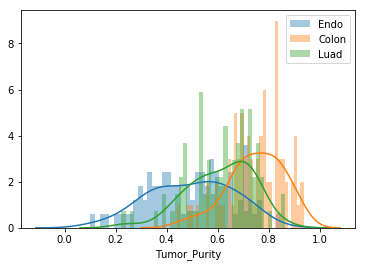

In [11]:
# Find tumor purity cutoffs 
purity_cutoff = {}

for c in cancer_objects:
    print(c)
    all_df = all_prot_format_df(cancer_objects[c], ['KRAS'], gene_in = 'KRAS')
    purity = get_tumor_purity(cancer_objects[c])
    miss_wt = all_df.join(purity, how = 'left')
    s = miss_wt['Tumor_Purity']

    #print('min:', s.min())
    #print('median:', s.median())
    #print('max:', s.max(), '\n')
    sns.distplot(s, bins = 40, label = c)
    plt.legend()
    #plt.show() # uncomment to see plots separately

    percent = 5
    cutoff = np.nanpercentile(s, percent, interpolation = 'nearest')
    purity_cutoff[c] = cutoff
    print(str(percent)+'%:', cutoff)
    print('Num pure samples:', len(s.loc[s > cutoff]), '/', len(all_df), '\n')# (of samples with miss/wt for KRAS not all samples

In [11]:
purity_cutoff

{'Endo': 0.22946024, 'Colon': 0.557, 'Luad': 0.39836446978100504}

In [12]:
cancer_objects = {'Endo':en, 'Colon':col, 'Luad':l}

In [13]:
# Get total num prot cols
total_prot = {}
all_prot = []
for c in cancer_objects:
    df = cancer_objects[c].get_proteomics()
    if isinstance(df.keys(), pd.core.indexes.multi.MultiIndex):
        df = u.reduce_multiindex(df, levels_to_drop = 1)
    #df = rename_duplicate_cols(df) # make unique col names
    cols = list(df.columns)
    total_prot[c] = len(cols) # get total num genes
    all_prot = all_prot + cols 
all_prot = list(set(all_prot)) # get unique genes in proteomics for en, luad, colon

In [14]:
import warnings
warnings.filterwarnings('ignore')

gene = 'KRAS'
merged_dfs = {}

# Uncomment to choose a get interacting function
prot_list = all_prot # List of all proteins
#prot_list = get_all_interacting_proteins(gene, 100)
#prot_list = list(u.get_interacting_proteins_bioplex(gene))
#prot_list = list(u.get_interacting_proteins_wikipathways(gene))
#prot_list = list(u.get_interacting_proteins_string(gene, num_results=1000))

#prot_list = list(u.get_interacting_proteins_biogrid(gene, num_results=4000)) # recommended
print('Interacting genes:', len(prot_list))

for cancer in cancer_objects:
    print(cancer) 
    
    # Format df for t-test
    mut_wt = all_prot_format_df(cancer_objects[cancer], prot_list)
    col_before = len(mut_wt.columns) - 2
    mut_wt = mut_wt.dropna(axis = 'columns', how = 'all') #drop cols with only nan 
    col_after = len(mut_wt.columns) - 2
    print(col_before, '->', col_after, '(dropped na)')
    
    # Keep more pure tumors
    purity = get_tumor_purity(cancer_objects[cancer])
    mut_wt = mut_wt.join(purity, on = "Patient_ID", how = "left")
    mut_wt = mut_wt.loc[mut_wt['Tumor_Purity'] > purity_cutoff[cancer]]
    #print('cutoff:', purity_cutoff[cancer])
    print('\tmin tumor purity:', mut_wt.Tumor_Purity.min())

    # T-test
    cols_in = list(mut_wt.columns[:-3]) #ccc
    print('cols tested: ', len(cols_in), '/', total_prot[cancer])

    # Get all pvals
    min_num = 20
    all_pval = u.wrap_ttest(mut_wt, 'Mutation', cols_in, return_all = True, correction_method = 'fdr_bh', mincount = min_num)
    all_pval = all_pval.rename(columns = {'Comparison': 'Proteomics','P_Value': cancer+'_P_Value'})
    
    # Get difference in medians
    delta_median_df = get_change_in_medians_df(cancer_objects[cancer], cancer, mut_wt, cols_in)

    # Merge pval_df and delta_median_df
    pval_medians_df = all_pval.merge(delta_median_df, on='Proteomics', how='outer')
    pval_medians_df = pval_medians_df.replace(to_replace = r'_proteomics', value = '', regex = True)
    merged_dfs[cancer] = pval_medians_df # testing purposes
    
    print(pval_medians_df.head(), '\n')

Interacting genes: 12336
Endo
12336 -> 10993 (dropped na)
	min tumor purity: 0.24094175
cols tested:  10993 / 10999
  Proteomics  Endo_P_Value  Endo_Median
0      SPRY1      0.001409       0.8869
1    ZFYVE19      0.020195       0.3360
2      MUC5B      0.032320       2.0780
3      FSTL1      0.035622       0.9610
4   CDC42SE2      0.035622       0.4850 

Colon
12336 -> 8059 (dropped na)
	min tumor purity: 0.562
cols tested:  8059 / 8067
  Proteomics  Colon_P_Value  Colon_Median
0       EEA1       0.847503       0.21400
1      CHID1       0.847503       0.22870
2     NUDCD1       0.847503      -0.19015
3      CELF1       0.847503      -0.13565
4     DICER1       0.847503       0.22080 

Luad
12719 -> 10699 (dropped na)
	min tumor purity: 0.4167809745510229
cols tested:  10699 / 10699
  Proteomics  Luad_P_Value  Luad_Median
0      TUFT1      0.000714      1.75850
1      DOCK5      0.000714      1.19640
2         F3      0.002223      2.84600
3     ZNF806      0.002767     -1.27875
4    

# Get number of significant genes in each cancer

In [15]:
# Using corrected pvals from wrap_ttest, each cancer's cutoff is 0.05
all_sig = []

for cancer in merged_dfs:
    df = merged_dfs[cancer]
    sig_df = df.loc[df[cancer+'_P_Value'] < 0.05]
    print(cancer, 'sig comparisons:', len(sig_df))
    sig_list = list(sig_df['Proteomics'])
    all_sig.append(sig_list)
        

flat_list = [item for sublist in all_sig for item in sublist] #change list of lists, to just one list
sig = list(set(flat_list)) # keep only one if gene in multiple cancer sig lists
print('\nNumber of significant comparisons in at least 1 cancer:', len(sig))

Endo sig comparisons: 5
Colon sig comparisons: 0
Luad sig comparisons: 96

Number of significant comparisons in at least 1 cancer: 101


In [16]:
# sig in multiple cancers
mult = list(set(i for i in flat_list if flat_list.count(i) > 1)) # Keep genes sig in more than 1 cancer
print('Number of significant genes in mult cancers:', len(mult))

Number of significant genes in mult cancers: 0


In [17]:
ca = 'Endo'
df = merged_dfs[ca]
df.loc[df[ca+'_P_Value'] < 0.05]

,Proteomics,Endo_P_Value,Endo_Median
0,SPRY1,0.001409,0.8869
1,ZFYVE19,0.020195,0.3360
2,MUC5B,0.032320,2.0780
3,FSTL1,0.035622,0.9610
4,CDC42SE2,0.035622,0.4850


In [21]:
ca = 'Luad'
df = merged_dfs[ca]
l_sig = df.loc[df[ca+'_P_Value'] < 0.05]
l_sig_list = list(l_sig.Proteomics)

In [27]:
prot_enr = gp.enrichr(gene_list = l_sig_list, description='Tumor_partition', gene_sets='Reactome_2016', 
                       outdir='/Enrichr')

In [28]:
prot_enr.res2d.head()

,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Gene_set
0,Laminin interactions Homo sapiens R-HSA-3000157,4/23,0.000004,0.006296,0,0,36.231884,449.306498,ITGB1;LAMB3;LAMA4;LAMB1,Reactome_2016
1,Non-integrin membrane-ECM interactions Homo sa...,4/42,0.000049,0.037109,0,0,19.841270,197.098815,ITGB1;LAMB3;LAMA4;LAMB1,Reactome_2016
2,Cell surface interactions at the vascular wall...,5/101,0.000126,0.064400,0,0,10.313531,92.585135,ITGB1;CD74;GRB7;MMP1;TREM1,Reactome_2016
3,IRS activation Homo sapiens R-HSA-74713,2/5,0.000226,0.086394,0,0,83.333333,699.630099,IRS1;IRS2,Reactome_2016
4,PI3K Cascade Homo sapiens R-HSA-109704,4/79,0.000569,0.173999,0,0,10.548523,78.821658,EEF2K;IRS1;GAB1;IRS2,Reactome_2016
